# 세팅

In [4]:
import os
import numpy as np
import torch
import torch.nn as nn
import torchvision

from torch.utils.data import DataLoader
#from torchvision.utils import draw_bounding_boxes
from torchvision.io import read_image
from torchvision.transforms import ToPILImage

from torchvision.models.detection import MaskRCNN, RetinaNet
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.ops import MultiScaleRoIAlign, FeaturePyramidNetwork
from torchvision.ops.feature_pyramid_network import LastLevelMaxPool

import random
import torch.backends.cudnn as cudnn
#import matplotlib.pyplot as plt
import utils
from torchvision.models.detection.mask_rcnn import _resnet_fpn_extractor, _validate_trainable_layers

In [13]:
import sys, os
sys.path.insert(0, os.path.join(os.getcwd(), "swin_t", "mmdet", "models", "backbones"))
sys.path.insert(0, os.path.join(os.getcwd(), "reference_detection"))

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset

import torchvision
from torchvision.utils import draw_bounding_boxes
from torchvision.io import read_image
from torchvision.transforms import ToPILImage

import random
import torch.backends.cudnn as cudnn

from torchvision.models.detection import MaskRCNN, RetinaNet
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.ops import MultiScaleRoIAlign
from torchvision.ops import FeaturePyramidNetwork

from torchvision.ops import misc as misc_nn_ops
from torchvision.ops.feature_pyramid_network import LastLevelP6P7, LastLevelMaxPool
from torchvision.models.detection.mask_rcnn import _resnet_fpn_extractor, _validate_trainable_layers

from torchinfo import summary

import matplotlib.pyplot as plt
from PIL import Image


import utils
import transforms as T
from engine import train_one_epoch, evaluate

#import swin_transformer

In [14]:
random_seed = 42

torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)
np.random.seed(random_seed)
cudnn.benchmark = False
cudnn.deterministic = True
random.seed(random_seed)

In [15]:
ROOT = os.path.join(os.getcwd(), 'dataset')
PED_DATA_DIR = os.path.join(ROOT, 'PennFudanPed')

In [16]:
import os
import numpy as np
import torch
from PIL import Image


class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)
        # convert the PIL Image into a numpy array
        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [17]:
def get_transform(train):
    transforms = []
    transforms.append(T.PILToTensor())
    transforms.append(T.ConvertImageDtype(torch.float))
    #transforms.append(T.FixedSizeCrop(700, 700)) # image size 고정
    transforms.append(T.FixedSizeCrop(1280, 800)) # image size 고정
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [18]:
dataset_ped = PennFudanDataset(PED_DATA_DIR, get_transform(train=True))
dataset_test_ped = PennFudanDataset(PED_DATA_DIR, get_transform(train=False))

indices = torch.randperm(len(dataset_ped)).tolist()
dataset_ped = torch.utils.data.Subset(dataset_ped, indices[:-50])
dataset_test_ped = torch.utils.data.Subset(dataset_test_ped, indices[-50:])

# define training and validation data loaders
data_loader_ped = torch.utils.data.DataLoader(
    dataset_ped, batch_size=2, shuffle=True,
    collate_fn=utils.collate_fn)

data_loader_test_ped = torch.utils.data.DataLoader(
    dataset_test_ped, batch_size=1, shuffle=False,
    collate_fn=utils.collate_fn)
    
num_classes_ped = 2

AttributeError: module 'utils' has no attribute 'collate_fn'

In [ ]:
# dataset = PennFudanDataset(DATA_DIR, get_transform(train=True))
# dataset_test = PennFudanDataset(DATA_DIR, get_transform(train=False))

# indices = torch.randperm(len(dataset)).tolist()
# dataset = torch.utils.data.Subset(dataset, indices[:-50])
# dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# # define training and validation data loaders
# data_loader = torch.utils.data.DataLoader(
#     dataset, batch_size=2, shuffle=True,
#     collate_fn=utils.collate_fn)

# data_loader_test = torch.utils.data.DataLoader(
#     dataset_test, batch_size=1, shuffle=False,
#     collate_fn=utils.collate_fn)
    
# num_classes_ped= 2

# Backbone

In [ ]:
from torchvision.ops import misc as misc_nn_ops
from torchvision.ops.feature_pyramid_network import LastLevelP6P7
from torchvision.models.detection.mask_rcnn import _resnet_fpn_extractor, _validate_trainable_layers

trainable_backbone_layers = _validate_trainable_layers(True, None, 5, 3)
resnet_50 = torchvision.models.resnet50(weights="DEFAULT", norm_layer=misc_nn_ops.FrozenBatchNorm2d)
mask_fpn = _resnet_fpn_extractor(resnet_50, trainable_backbone_layers)
retina_fpn = _resnet_fpn_extractor(resnet_50, trainable_backbone_layers, returned_layers=[2, 3, 4], extra_blocks=LastLevelP6P7(256, 256))
use_fpn = False

mask_backbone = mask_fpn
retina_backbone = retina_fpn
mask_backbone.out_channels = retina_backbone.out_channels = 256


In [ ]:
import sys
sys.path.insert(0, os.path.join(os.getcwd(), "swin_t", "mmdet", "models", "backbones"))

import swin_transformer


apex is not installed


In [ ]:
swint_backbone = swin_transformer.SwinTransformer()

c:\Users\euna\miniconda3\envs\project\lib\site-packages\torch\functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
#import myViG
from myViG import pvig_ti_224_gelu, pvig_s_224_gelu, pvig_m_224_gelu, pvig_b_224_gelu

pvig_ti = pvig_ti_224_gelu()
pvig_s = pvig_s_224_gelu()
pvig_m = pvig_m_224_gelu()
pvig_b = pvig_b_224_gelu()

<myViG.pvig_ti_224_gelu.<locals>.OptInit object at 0x000001F30EE09690>
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
<myViG.pvig_s_224_gelu.<locals>.OptInit object at 0x000001F34C962C80>
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
<myViG.pvig_m_224_gelu.<locals>.OptInit object at 0x000001F319713D30>
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using relative_pos
using rela

In [ ]:
backbone = swint_backbone
backbone.out_channels = 768

In [ ]:
trainable_backbone_layers = _validate_trainable_layers(True, None, 5, 3)
resnet_50 = torchvision.models.resnet50(weights="DEFAULT", norm_layer=misc_nn_ops.FrozenBatchNorm2d)
mask_resnet_fpn = _resnet_fpn_extractor(resnet_50, trainable_backbone_layers)
retina_resnet_fpn = _resnet_fpn_extractor(resnet_50, trainable_backbone_layers, returned_layers=[2, 3, 4], extra_blocks=LastLevelP6P7(256, 256))

mask_resnet_fpn.out_channels = retina_resnet_fpn.out_channels = 256

In [ ]:
fpn = FeaturePyramidNetwork(
            in_channels_list=[96, 192, 384, 768],
            out_channels=256,
            extra_blocks=LastLevelP6P7(256, 256)# LastLevelMaxPool(),
        )

In [ ]:
pvig_fpn = nn.Sequential(pvig_ti, fpn)
pvig_fpn.out_channels = 256

In [ ]:
mask_backbone = pvig_ti
retina_backbone = pvig_ti
use_fpn = True
num_classes = num_classes_ped
mask_backbone.out_channels = 1280

In [ ]:
#pvig_ti
import torch
PKL_PATH = os.path.join(os.getcwd(), 'archive', 'data.pkl')
#state_dict = torch.load(PKL_PATH)
pvig_ti.load_state_dict(torch.load(PKL_PATH), strict=False)

UnpicklingError: A load persistent id instruction was encountered,
but no persistent_load function was specified.

# MaskRCNN

In [ ]:
pre_mask = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

if use_fpn:
    anchor_generator = AnchorGenerator(
        sizes=((32,), (64,), (128,), (256,), (512,)),
        aspect_ratios=((0.5, 1.0, 2.0),
                       (0.5, 1.0, 2.0),
                       (0.5, 1.0, 2.0),
                       (0.5, 1.0, 2.0),
                       (0.5, 1.0, 2.0)))
else:
    anchor_generator = AnchorGenerator(
        sizes=((32, 64, 128),),
        aspect_ratios=((0.5, 1.0, 2.0),))

roi_pooler = MultiScaleRoIAlign(featmap_names=['0'],
                                output_size=7,
                                sampling_ratio=2)

mask_roi_pooler = MultiScaleRoIAlign(featmap_names=['0'],
                                                        output_size=14,
                                                        sampling_ratio=2)

custom_mask = MaskRCNN(
    mask_backbone,
    num_classes=num_classes,
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=roi_pooler,
    mask_roi_pool=mask_roi_pooler,)

# RetinaNet

In [ ]:
pre_retina = torchvision.models.detection.retinanet_resnet50_fpn(weights="DEFAULT")
if use_fpn:
    anchor_generator = AnchorGenerator(
        sizes=((32,), (64,), (128,), (256,), (512,)),
        aspect_ratios=((0.5, 1.0, 2.0),
                       (0.5, 1.0, 2.0),
                       (0.5, 1.0, 2.0),
                       (0.5, 1.0, 2.0),
                       (0.5, 1.0, 2.0)))
else:
    anchor_generator = AnchorGenerator(
        sizes=((32, 64, 128),),
        aspect_ratios=((0.5, 1.0, 2.0),))


custom_retina = RetinaNet(
    backbone,
    num_classes=num_classes,
    anchor_generator=anchor_generator
)

Downloading: "https://download.pytorch.org/models/retinanet_resnet50_fpn_coco-eeacb38b.pth" to C:\Users\euna/.cache\torch\hub\checkpoints\retinanet_resnet50_fpn_coco-eeacb38b.pth
100.0%


# Training

In [ ]:

i = iter(data_loader_test)
images, targets = next(i)
images = list(img.to(device) for img in images)
predictions = model(images)
img = images[0].detach() * 255 # C x H x W
img = img.type(torch.uint8) 

NameError: name 'data_loader_test' is not defined

In [ ]:
x = next(i)

In [ ]:
swint_backbone(x)

In [ ]:
data_loader = data_loader_ped
data_loader_test = data_loader_test_ped


# pre_retina # custom_retina # custom_mask # pre_mask
model = custom_mask

In [ ]:
# For Training
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=3,
                                                gamma=0.1)

# let's train it for 10 epochs
num_epochs = 10
num_epochs = 10

In [ ]:
data_loader

In [ ]:
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

print("That's it!")

RuntimeError: The size of tensor a (200) must match the size of tensor b (56) at non-singleton dimension 3

In [ ]:
model.eval()

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): DeepGCN(
    (stem): Stem(
      (convs): Sequential(
        (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): GELU(approximate=none)
        (3): Conv2d(24, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (4): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): GELU(approximate=none)
        (6): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (7): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (backbone): Sequential(
      (0): Sequential(
        (0): Grapher(
          (fc1): Sequential(
            (0): Conv2d(48, 48, kernel_si

In [ ]:
model.eval()

RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256, e

In [ ]:
i = iter(data_loader_test)

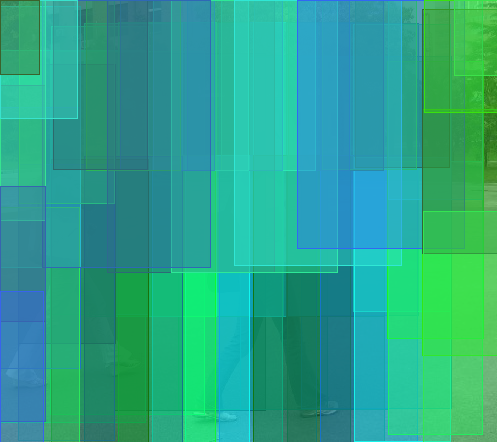

In [ ]:
images, targets = next(i)
images = list(img.to(device) for img in images)
predictions = model(images)
img = images[0].detach() * 255 # C x H x W
img = img.type(torch.uint8) 
boxes = predictions[0]['boxes'] # xmin, ymin, xmax, ymax
img_with_bbox = draw_bounding_boxes(
    image=img, 
    boxes=boxes,
    fill=True).detach().cpu()
# plt.imshow(img_with_bbox.permute(1, 2, 0)) # H x W x C
ToPILImage()(img_with_bbox)